# 5. Pretraining on Unlabeled Data

> LLMs from Scratch

- Minjae Gwon
  <minjae.gwon@postech.ac.kr>
  <https://bxta.kr>

- ML Lab
  <https://ml.postech.ac.kr>

- CompSec Lab
  <https://compsec.postech.ac.kr>

## 5.1 Evaluating generative text models

### 5.1.1 Using GPT to generate text

- 텍스트 생성 과정을 간단히 복습하기 위해 LLM을 셋업.
  - 트레이닝에 필요한 컴퓨팅 자원을 줄이기 위해 이전 장에 비해 context length를 줄였음.
  - 최근 LLMs는 드롭아웃을 사용하지 않는 경향이 잇음.
  - 최근 LLMs는 bias vector를 사용하지 않는 경향이 있음.

In [1]:
import torch

from llm_from_scratch.chapter_05.lib import GPTConfig, GPTModel

GPT_CONFIG_124M: GPTConfig = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False,
}

torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)

model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

- `GPTModel`을 이용해서 텍스트를 생성해보자.

![](https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/gpt-process.webp)

In [2]:
import tiktoken
from tiktoken import Encoding
from torch import Tensor

from llm_from_scratch.chapter_05.lib import generate_text_simple


def text_to_token_ids(text: str, tokenizer: Encoding):
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # add batch dimension
    return encoded_tensor


def token_ids_to_text(token_ids: Tensor, tokenizer: Encoding):
    flat = token_ids.squeeze(0)  # remove batch dimension
    return tokenizer.decode(flat.tolist())


start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"],
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


- 모델이 트레이닝되지 않았기 때문에, 무의미한 텍스트가 생성됨.

### 5.1.2 Calculating the Text Generation Loss

- "의미 있는" 텍스트를 생성하기 위한 기준에 대해 알아볼 것임.
- 2개의 트레이닝 example로 이루어진 `inputs` 텐서와 그에 상응하는 `targets` 텐서가 있다고 해보자.
  - `targets` 텐서는 `inputs` 텐서를 한 칸 민 형태를 가지고 있음. (Chapter 2 참조)

In [3]:
inputs = torch.tensor(
    [[16833, 3626, 6100], [40, 1107, 588]]
)  # ["every effort moves", "I really like"]

targets = torch.tensor(
    [[3626, 6100, 345], [1107, 588, 11311]]
)  # [" effort moves you", " really like chocolate"]

- `inputs`를 모델에 넣으면 우리는 `logits` 텐서를 얻게 됨.
- 이를 `softmax` 함수에 넣어서 `logits` 텐서를 확률 텐서로 변환할 수 있음.

In [4]:
with torch.no_grad():
    logits = model(inputs)

probabilities = torch.softmax(logits, dim=-1)  # Probability of each token in vocabulary

print(probabilities.shape)  # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


- `argmax`를 이용해서 확률 scores를 predicted token IDs로 변환할 수 있음.
  - `argmax`는 가장 높은 확률을 가지는 token ID를 선택함.

In [5]:
token_ids = torch.argmax(probabilities, dim=-1, keepdim=True)

print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [6]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


- 하지만 모델이 트레이닝 되어 있지 않기 때문에 `targets`와는 다소 다른 token IDs가 생성된 모습을 확인할 수 있음.
- 모델을 트레이닝 하기 위해서는 생성된 결과가 `targets`와 얼마나 멀리 떨어져 있는지를 알아야 함.

- `target`에 상응하는 확률은 아래와 같음.

In [7]:
text_idx = 0
target_probabilities_1 = probabilities[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probabilities_1)

text_idx = 1
target_probabilities_2 = probabilities[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probabilities_2)

Text 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


- 이때 우리의 목표는 위의 각 확률을 1에 가깝게 최대화하는 것이고, log를 취해서 계산할 것임.
    - 수학적 최적화에서 확률 점수의 로그를 최대화하는 것이 더 쉬운 이유:
        - **곱셈을 덧셈으로 변환**: 곱셈 연산을 덧셈 연산으로 변환하여 계산을 간단하게 만듦.
        - **수치적 안정성**: 작은 확률 값으로 인한 언더플로우 문제를 피할 수 있음.
        - **미분의 간편성**: 로그 함수는 미분하기 더 쉬움.
        - **오목성**: 로그 함수는 오목(convex)하여 최적화 문제를 더 쉽게 해결할 수 있음.

In [8]:
log_probabilities = torch.log(
    torch.cat((target_probabilities_1, target_probabilities_2))
)

print("Log probabilities:", log_probabilities)

Log probabilities: tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


- 이들의 평균을 구하면 아래와 같음.

In [9]:
average_log_probability = torch.mean(log_probabilities)

print("Average log probability:", average_log_probability)

Average log probability: tensor(-10.7940)


- "각 확률을 1에 가깝게 최대화 하는" 목표는 "위의 평균값을 0에 가깝게 만드는 것"과 동일한 문제로 변환됨.

- 딥러닝에서는 average log-probability를 최대화하는 것이 아니라, negative log-likelihood를 최소화하는 것이 일반적임.
- 즉, 위에서 구한 -10.7940에 -1을 곱한 값인 10.7940가 loss 값이 되며 이를 cross-entropy loss라고 함.

In [10]:
negative_average_log_probability = -average_log_probability

print("Negative average log probability:", negative_average_log_probability)

Negative average log probability: tensor(10.7940)


![](https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/cross-entropy.webp?123)

- PyTorch에는 이전 과정을 한 번에 계산해주는 `cross_entropy`가 이미 구현되어 있음.
- PyTorch의 `cross_entropy`를 이용하기 위해서는 텐서를 flatten된 형태로 변환해야 함.

In [11]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits shape:", logits_flat.shape)
print("Flattened targets shape:", targets_flat.shape)

Flattened logits shape: torch.Size([6, 50257])
Flattened targets shape: torch.Size([6])


- `targets`는 `logits` 텐서에서 최대화하고 싶은 인덱스를 가지고 있음. 
- PyTorch의 `cross_entropy`는 내부적으로 softmax와 log-probability 계산을 적용해서 최대화하고 싶은 token indices에 대해 계산함.

In [12]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


- 위에서 구한 cross-entropy loss에 exp를 취해서 perplexity를 계산할 수 있음.
- Perplexity는 모델이 얼마나 확신을 가지고 텍스트를 생성하는지를 나타내는 지표임.
  - Perplexity가 낮을수록 모델이 더 확신을 가지고 텍스트를 생성함.

In [13]:
perplexity = torch.exp(loss)

print(perplexity)

tensor(48725.8203)


### 5.1.3 Calculating the Training and Validation Set Losses

- 실습을 위해서 chapter 2에서도 사용한 "The Verdict"를 사용할 것임.

In [14]:
import urllib.request

url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

with urllib.request.urlopen(url) as response:
    text_data = response.read().decode("utf-8")

In [15]:
# First 100 characters
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [16]:
# Last 100 characters
print(text_data[-99:])

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [17]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


![](https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/batching.webp)

- 위 이야기를 training set과 validation set으로 나누고 dataloader의 형태로 만들어줌.

In [18]:
from llm_from_scratch.chapter_05.lib import create_dataloader_v1

# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0,
)

validation_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0,
)

# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print(
        "Not enough tokens for the training loader. "
        "Try to lower the `GPT_CONFIG_124M['context_length']` or "
        "increase the `training_ratio`"
    )

if total_tokens * (1 - train_ratio) < GPT_CONFIG_124M["context_length"]:
    print(
        "Not enough tokens for the validation loader. "
        "Try to lower the `GPT_CONFIG_124M['context_length']` or "
        "decrease the `training_ratio`"
    )

- An optional check that the data was loaded correctly:

In [19]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in validation_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


- Another optional check that the token sizes are in the expected ballpark:

In [20]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in validation_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


- 이후 주어진 배치에서의 loss를 계산하는 함수와 전체 데이터셋에서의 loss를 계산하는 함수를 정의할 것임.

In [21]:
from torch import Tensor, device, nn
from torch.utils.data import DataLoader


def loss_of_batch(
    input_batch: Tensor, target_batch: Tensor, model: nn.Module, device: device
):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)

    logits = model(input_batch)

    loss = nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())

    return loss


def loss_of_dataloader(
    dataloader: DataLoader[tuple[Tensor, Tensor]],
    model: nn.Module,
    device: device,
    num_batches: int | None = None,
):
    total_loss: float = 0.0

    if len(dataloader) == 0:
        return float("nan")

    if num_batches is None:
        num_batches = len(dataloader)
    else:
        num_batches = min(num_batches, len(dataloader))

    for i, (input_batch, target_batch) in enumerate(dataloader):
        if i >= num_batches:
            break

        loss = loss_of_batch(input_batch, target_batch, model, device)
        total_loss += loss.item()

    return total_loss / num_batches

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = loss_of_dataloader(train_loader, model, device)
    validation_loss = loss_of_dataloader(validation_loader, model, device)

print("Train loss:", train_loss)
print("Validation loss:", validation_loss)

Train loss: 10.987583372328016
Validation loss: 10.98110580444336


## 5.2 Training an LLM

![](https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/train-steps.webp)

In [23]:
import torch.utils
from tiktoken import Encoding
from torch.optim import Optimizer


def train_model_simple(
    model: nn.Module,
    train_loader: DataLoader[tuple[Tensor, Tensor]],
    validation_loader: DataLoader[tuple[Tensor, Tensor]],
    optimizer: Optimizer,
    device: torch.device,
    num_epochs: int,
    eval_freq: float,
    eval_iter: int,
    start_context: str,
    tokenizer: Encoding,
):
    # Initialize lists to track losses and tokens seen
    train_losses: list[float] = []
    validation_losses: list[float] = []
    track_tokens_seen: list[int] = []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration
            loss = loss_of_batch(input_batch, target_batch, model, device)
            loss.backward()  # Calculate loss gradients
            optimizer.step()  # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, validation_loss = evaluate_model(
                    model, train_loader, validation_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                validation_losses.append(validation_loss)
                track_tokens_seen.append(tokens_seen)
                print(
                    f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, Val loss {validation_loss:.3f}"
                )

        # Print a sample text after each epoch
        generate_and_print_sample(model, tokenizer, device, start_context)

    return train_losses, validation_losses, track_tokens_seen


def evaluate_model(
    model: nn.Module,
    train_loader: DataLoader[tuple[Tensor, Tensor]],
    validation_loader: DataLoader[tuple[Tensor, Tensor]],
    device: torch.device,
    eval_iter: int,
):
    model.eval()
    with torch.no_grad():
        train_loss = loss_of_dataloader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = loss_of_dataloader(
            validation_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(
    model: nn.Module, tokenizer: Encoding, device: torch.device, start_context: str
):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded, max_new_tokens=50, context_size=context_size
        )
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

- 위 코드를 이용하여 트레이닝 하면 아래와 같은 결과를 얻을 수 있음.

In [24]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, validation_losses, tokens_seen = train_model_simple(
    model,
    train_loader,
    validation_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context="Every effort moves you",
    tokenizer=tokenizer,
)

Ep 1 (Step 000000): Train loss 9.818, Val loss 9.928
Ep 1 (Step 000005): Train loss 8.065, Val loss 8.335
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.622, Val loss 7.051
Ep 2 (Step 000015): Train loss 6.047, Val loss 6.600
Every effort moves you, and,, and,,,,,,, and,.                                   
Ep 3 (Step 000020): Train loss 5.586, Val loss 6.477
Ep 3 (Step 000025): Train loss 5.523, Val loss 6.399
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and
Ep 4 (Step 000030): Train loss 5.128, Val loss 6.366
Ep 4 (Step 000035): Train loss 4.941, Val loss 6.366
Every effort moves you a a to the a. Gisburn, and a. Gisburn. I had the of the of the of the of the of the of the of the of the of the of the of the of the of the. I had a
Ep 5 (Step 000040): Train loss 4.340, Val loss 6.246
Every effort moves you, with a, in the of the pi

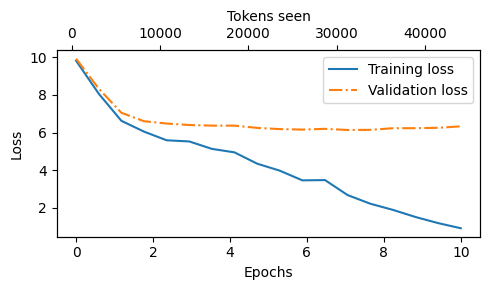

In [25]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(
    epochs_seen: Tensor,
    tokens_seen: list[int],
    train_losses: list[float],
    validation_losses: list[float],
):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, validation_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(
        MaxNLocator(integer=True)
    )  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.show()


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, validation_losses)

- 위의 결과를 보면 모델이 처음에는 이해할 수 없는 단어 문자열을 생성하지만, 나중에는 문법적으로 어느 정도 맞는 문장을 생성할 수 있게 됨
- 그러나 학습 및 검증 세트 손실을 보면 모델이 overfitting되기 시작하는 것을 알 수 있음.
  - 여기서 overfitting이 발생하는 이유는 훈련 세트가 매우 작고, 여러 번 반복해서 학습했기 때문.
- 모델이 마지막에 작성한 몇 가지 구절을 확인해 보면, 그 구절들이 훈련 세트에 그대로 포함되어 있는 것을 발견할 수 있습니다. 이는 모델이 단순히 훈련 데이터를 암기하는 것임을 확인할 수 있음.
- 이후에 이러한 암기를 어느 정도 완화할 수 있는 디코딩 전략을 다룰 예정임.

## 5.3 Decoding Strategies to Control Randomness

In [26]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"],
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




- `generate_text_simple` 함수를 여러 번 실행하더라도 LLM은 항상 동일한 출력을 생성함.
- 이제 `generate_text_simple`을 수정하기 위해 두 가지 디코딩 전략을 소개함: *temperature scaling*과 *top-k* 샘플링.
- 이를 통해 모델이 생성하는 텍스트의 무작위성과 다양성을 제어할 수 있음.

### 5.3.1 Temperature scaling

- 이전에는 항상 `torch.argmax`을 사용하여 가장 높은 확률을 가진 토큰을 다음 토큰으로 샘플링했음.
- 다양성을 추가하기 위해 `torch.multinomial(probs, num_samples=1)`을 사용하여 확률 분포에서 다음 토큰을 샘플링할 수 있음.
- 여기서 각 인덱스가 선택될 확률은 입력 텐서에서 해당 인덱스의 확률에 대응함.

- 다음 토큰을 생성하는 과정에 대한 간단한 요약을 제공함, 예시를 위해 매우 작은 어휘를 가정함:

In [27]:
from typing import cast

vocabulary = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocabulary = {v: k for k, v in vocabulary.items()}

# Suppose input is "every effort moves you", and the LLM
# returns the following logits for the next token:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probabilities = torch.softmax(next_token_logits, dim=0)
next_token_id = cast(int, torch.argmax(probabilities).item())

# The next generated token is then as follows:
print(inverse_vocabulary[next_token_id])

forward


In [28]:
torch.manual_seed(123)

next_token_id = cast(int, torch.multinomial(probabilities, num_samples=1).item())

print(inverse_vocabulary[next_token_id])

toward


In [29]:
def print_sampled_tokens(probabilities: Tensor):
    torch.manual_seed(123)  # Manual seed for reproducibility
    sample = [
        torch.multinomial(probabilities, num_samples=1).item() for _ in range(1_000)
    ]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocabulary[i]}")


print_sampled_tokens(probabilities)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


- `torch.argmax`을 사용하여 가장 가능성 있는 토큰을 결정하는 대신, `torch.multinomial(probas, num_samples=1)`을 사용해 softmax 분포에서 샘플링하여 가장 가능성 있는 토큰을 결정함.
- 예시를 위해, 원래 softmax 확률을 사용하여 다음 토큰을 1,000번 샘플링할 때 어떤 일이 발생하는지 살펴보겠음:

- 분포와 선택 과정을 temperature scaling이라는 개념을 통해 제어할 수 있음.
- "Temperature scaling"은 로짓을 0보다 큰 숫자로 나누는 것을 의미함.
- 1보다 큰 온도는 softmax를 적용한 후 토큰 확률이 더 균일하게 분포되게 함.
- 1보다 작은 온도는 softmax를 적용한 후 확률 분포가 더 확신 있게(더 날카롭고 뾰족하게) 만듦.

In [30]:
def softmax_with_temperature(logits: Tensor, temperature: float):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)


# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probabilities = [
    softmax_with_temperature(next_token_logits, T) for T in temperatures
]

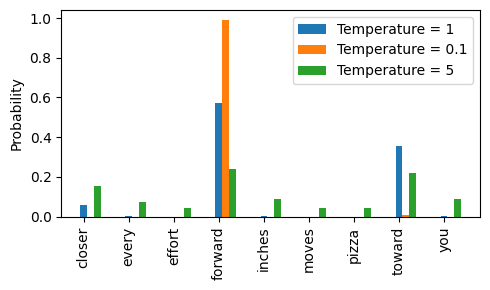

In [31]:
# Plotting
x = torch.arange(len(vocabulary))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(
        x + i * bar_width,
        scaled_probabilities[i],
        bar_width,
        label=f"Temperature = {T}",
    )

ax.set_ylabel("Probability")
ax.set_xticks(x)
ax.set_xticklabels(vocabulary.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

- 온도 0.1로 다시 스케일링하면 분포가 더 날카로워져 `torch.argmax`에 가까워지며, 가장 가능성 높은 단어가 거의 항상 선택되는 것을 볼 수 있음:

In [32]:
print_sampled_tokens(scaled_probabilities[1])

0 x closer
0 x every
0 x effort
992 x forward
0 x inches
0 x moves
0 x pizza
8 x toward


- The rescaled probabilities via temperature 5 are more uniformly distributed:

In [33]:
print_sampled_tokens(scaled_probabilities[2])

153 x closer
68 x every
55 x effort
223 x forward
102 x inches
50 x moves
43 x pizza
218 x toward
88 x you


- LLM 입력이 "every effort moves you"인 경우, 위 접근 방식을 사용하면 가끔씩 "every effort moves you pizza"와 같은 말이 안 되는 텍스트가 생성될 수 있음. 이는 1000번 중 32번, 즉 3.2%의 확률로 발생함.

### 5.3.2 Top-k sampling

- 출력의 다양성을 높이면서도 말이 안 되는 문장의 확률을 줄이기 위해, 더 높은 온도를 사용할 수 있도록 샘플링된 토큰을 상위 k개의 가장 가능성 높은 토큰으로 제한할 수 있음:

![](https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/topk.webp)


In [34]:
top_k = 3
top_logits, top_positions = torch.topk(next_token_logits, top_k)

print("Top logits:", top_logits)
print("Top positions:", top_positions)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [35]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")),
    other=next_token_logits,
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [36]:
top_k_probabilities = torch.softmax(new_logits, dim=0)
print(top_k_probabilities)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### 5.3.3 Modifying the Text Generation Function

In [37]:
def generate(
    model: nn.Module,
    token_ids: Tensor,
    max_new_tokens: int,
    context_size: int,
    temperature: float = 0.0,
    top_k: int | None = None,
    eos_token_id: int | None = None,
):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = token_ids[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits
            )

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            next_token_id = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            next_token_id = torch.argmax(
                logits, dim=-1, keepdim=True
            )  # (batch_size, 1)

        if (
            next_token_id == eos_token_id
        ):  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        token_ids = torch.cat(
            (token_ids, next_token_id), dim=1
        )  # (batch_size, num_tokens+1)

    return token_ids

In [38]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    token_ids=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4,
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know began to happen a little wild--I was such a sketch of enough
